# Introduction

The dataset consists of users, reviews, sentiment of the users of an e-commerce company. In a product recommendation system , sentiment analysis helps to recommend better products to the customer. This notebook focuses on the pre-processing and EDA of the reviews_text.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
import spacy
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv("data/sample30.csv")
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


## Data Cleaning

### Handling of missing values
* If the column/feature has more than 30% of missing values, then we can drop the column.
* Columns with missing values having True/False as values can be replaced with False.
* We can remove the rows for columns having fewer percentage of missing values.


In [3]:
# checking null values
df.isnull().sum()*100/len(df)

## reviews_userCity and reviews_userProvince has the most missing values

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

In [4]:
df['reviews_didPurchase']=df['reviews_didPurchase'].fillna(False)
df['reviews_doRecommend']=df['reviews_doRecommend'].fillna(False)
df['reviews_username']=df['reviews_username'].fillna('Unknown')
df=df.drop(['reviews_userCity','reviews_userProvince'],axis=1)
df['manufacturer']=df['manufacturer'].fillna('unknown')

In [5]:
# since only one row has missing sentiment we can use this to predict
predict_text = df[df['user_sentiment'].isnull()]['reviews_text']

In [6]:
df.dropna(subset=['user_sentiment'],axis=0,inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29999 non-null  object
 1   brand                29999 non-null  object
 2   categories           29999 non-null  object
 3   manufacturer         29999 non-null  object
 4   name                 29999 non-null  object
 5   reviews_date         29953 non-null  object
 6   reviews_didPurchase  29999 non-null  bool  
 7   reviews_doRecommend  29999 non-null  bool  
 8   reviews_rating       29999 non-null  int64 
 9   reviews_text         29999 non-null  object
 10  reviews_title        29809 non-null  object
 11  reviews_username     29999 non-null  object
 12  user_sentiment       29999 non-null  object
dtypes: bool(2), int64(1), object(10)
memory usage: 2.8+ MB


### Pre-processing of text data

Performing the below text cleaning steps :
* Changing all text to lower case
* Removing digits and punctuations , as It is relevant.
* Finding the lemma form of the word using spacy
* Find the word count after pre-processing

In [8]:
# text cleaning
import re
# defining function to pre-process text
nlp = spacy.load("en_core_web_sm")
def pre_process(text):
    text = text.lower()
    text=re.sub('\d|\!|\|:|\?|\.|,|-','',text)
    lemma = " ".join([ token.lemma_ for token in nlp(text) if not token.is_stop])
    return lemma

In [9]:
pre_processed_text=pre_process(df['reviews_text'][0])
print(f"Original Sentence:  {df['reviews_text'][0]} \n")
print(f"Pre-processed Sentence: {pre_processed_text}")

Original Sentence:  i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy. 

Pre-processed Sentence: love album good hip hop current pop sound hype listen everyday gym star rating way metaphor crazy


In [10]:
df['lemmatized_review'] = df['reviews_text'].apply(pre_process)

In [11]:
df['lemma_list']=df['lemmatized_review'].apply(lambda x: str(x).split())

In [12]:
df['word_count'] = df['lemma_list'].apply(lambda x: len(x))

In [13]:
# mapping positive to 1 and negative to 0
df['user_sentiment']=df['user_sentiment'].map({'Positive':1,'Negative':0})

## Exploratory Data Analysis

## Univariate analysis

1. Checking the class imbalance of the data.
2. Frequency distribution plots
3. Most reviewed categories

Text(0.5, 1.0, 'Class imbalance of sentiment')

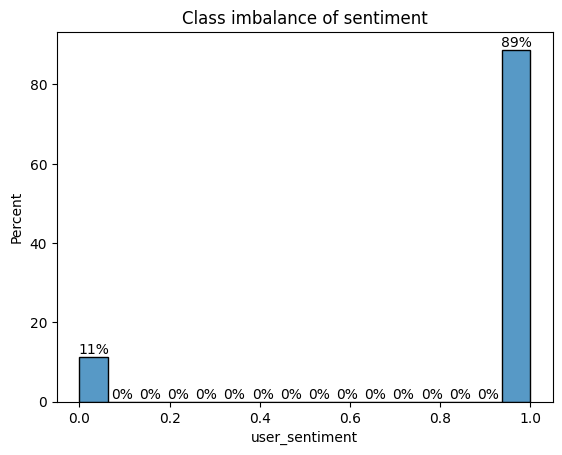

In [14]:
# Class imbalance
ax=sns.histplot(df['user_sentiment'],stat='percent')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
plt.title("Class imbalance of sentiment")
# There is class imbalance as we can see that 88% of data has positive reviews.

Text(0.5, 1.0, 'Frequency distribution of reviews_rating')

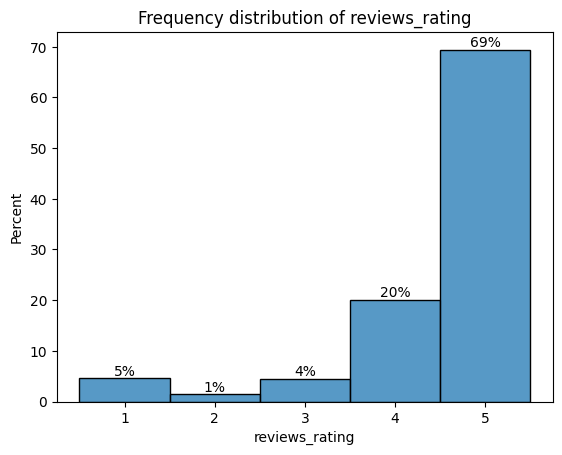

In [15]:
# 2.Frequency plot of rating
ax=sns.histplot(df['reviews_rating'],stat='percent',discrete='bool')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
plt.title("Frequency distribution of reviews_rating")

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0.5, 1.0, 'Frequency distribution of reviews puchased')

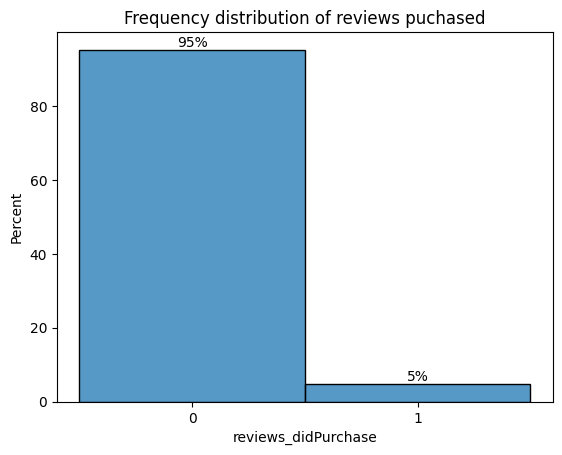

In [16]:
#4. frequency plot of reviews purchase
ax=sns.histplot(df['reviews_didPurchase'],stat='percent',discrete='bool')
ax.set_xticks([0,1])
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
plt.title("Frequency distribution of reviews puchased")

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0.5, 1.0, 'Frequency distribution of reviews recommended')

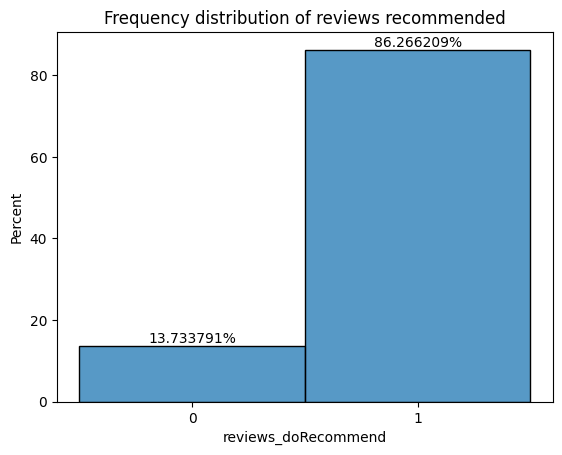

In [17]:
#5. frequency plot of reviews do recommend
ax=sns.histplot(df['reviews_doRecommend'],discrete='bool',stat='percent')
ax.set_xticks([0,1])
for container in ax.containers:
    ax.bar_label(container,fmt='%0f%%',)
plt.title("Frequency distribution of reviews recommended")

In [18]:
# top 5 brands which are reviewed
df['brand'].value_counts()[0:5]


Clorox               10585
Warner Home Video     3325
Disney                1199
L'oreal Paris         1186
FOX                    887
Name: brand, dtype: int64

In [19]:
# most common  categories

# combine all categories into one
all_categories="".join(df['categories'])
categories_list = all_categories.split(",")
from collections import Counter
Counter(categories_list).most_common(5)

[('Featured Brands', 14679),
 ('Health & Household', 11314),
 ('Household Supplies', 11238),
 ('Household Cleaning', 11103),
 ('Home And Storage & Org', 11065)]

## Bi-Variate Analysis

* word-count frequency distribution of positve and negative reviews
* word-count frequency distribution of ratings
* Find the most 10 common words in positive and negative reviews

Text(0.5, 1.0, 'Average word count in each rating')

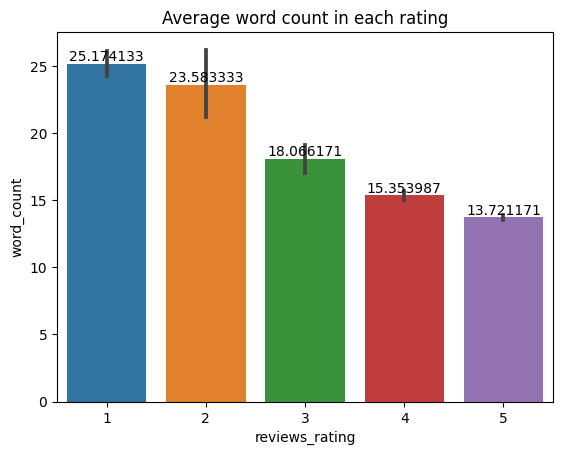

In [20]:
#df.groupby(by='reviews_rating')['word_count'].mean()
ax=sns.barplot(x='reviews_rating',y='word_count',data=df)
for container in ax.containers:
    ax.bar_label(container,fmt="%f")

plt.title("Average word count in each rating")

# negative ratings have a higher word count

Text(0.5, 1.0, 'Average word count in each sentiment category')

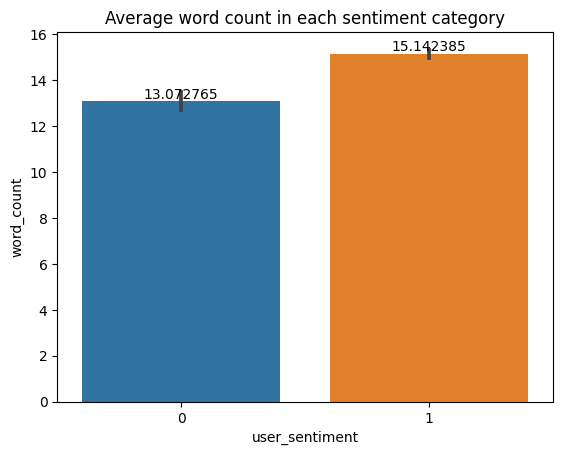

In [21]:
ax=sns.barplot(y='word_count',x='user_sentiment',data=df)
for container in ax.containers:
    ax.bar_label(container,fmt="%f")

plt.title("Average word count in each sentiment category")

#  suprising negative sentiments have lesser word counts

In [22]:
group_by=df.groupby(by="reviews_rating")['lemmatized_review'].apply(lambda x: Counter(''.join(x).split()).most_common(25))

In [23]:
words=[ele[0] for ele in group_by[1] ]
freq=[ele[1] for ele in group_by[1]]

Text(0.5, 1.0, 'Top 25 Most common words for rating 1')

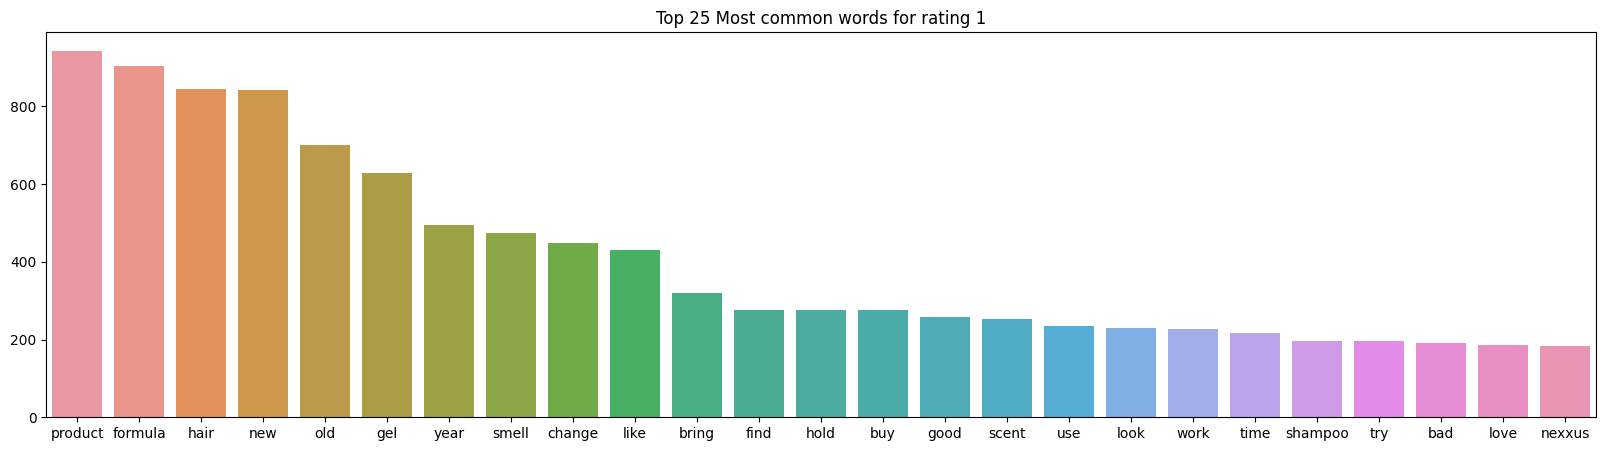

In [24]:
# plotting the frequency of most common words for rating 1
plt.figure(figsize=(20,5))
sns.barplot(x=words,y=freq)
plt.title("Top 25 Most common words for rating 1")

Text(0.5, 1.0, 'Top 25 Most common words for rating 5')

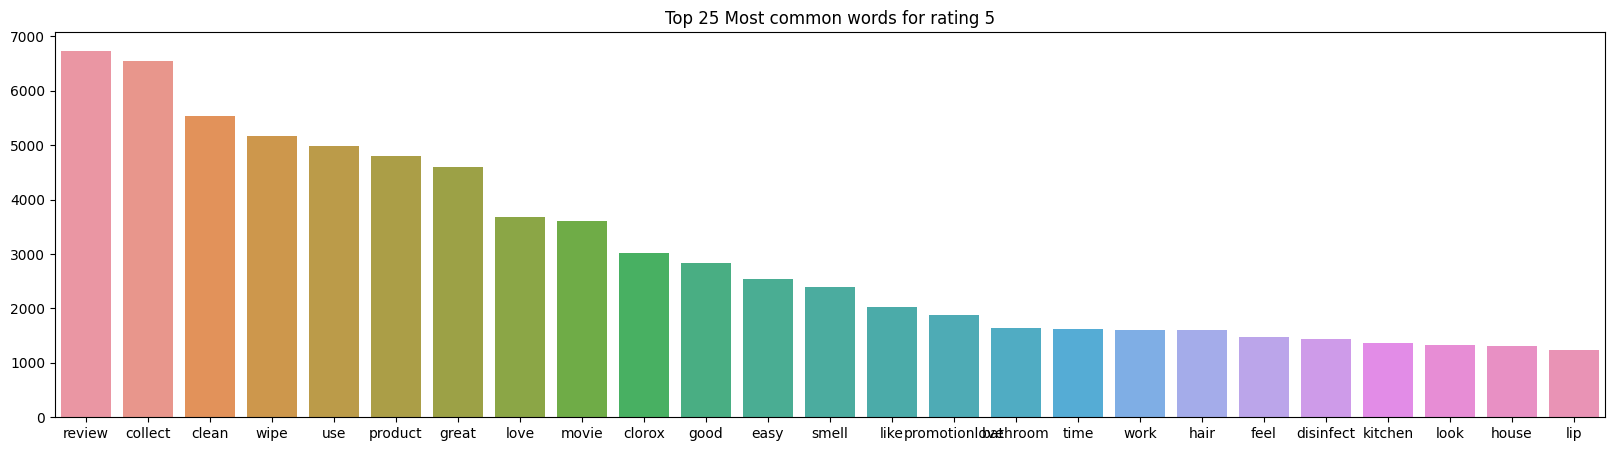

In [25]:
# plotting the frequency f most common words for rating 5
words=[ele[0] for ele in group_by[5] ]
freq=[ele[1] for ele in group_by[5]]
plt.figure(figsize=(20,5))
sns.barplot(x=words,y=freq)
plt.title("Top 25 Most common words for rating 5")

# BOW model

Creating bag of words representation of the reviews text. A bag of words representation checks the frequency of a word in the entire document.Using the CountVectorizer function from sklearn package to active the same.

In [26]:
vec = CountVectorizer(stop_words='english')
X=vec.fit_transform(df['lemmatized_review'])

In [27]:
X_transformed= X.toarray()

In [28]:
X_transformed.shape

(29999, 15952)

In [30]:
y= df['user_sentiment']

In [31]:
def createPickleFile(filename,data):
    with open(filename,'wb') as f:
        pickle.dump(data,f)

In [36]:
createPickleFile('bow_model_.pkl',vec)

In [41]:
df_final = df[['lemmatized_review','user_sentiment']]

In [43]:
df_final.to_csv('data/pre_process_data.csv', index=False)  

## TF-IDF

Creating TF-IDF representation of the reviews text. Term Frequency- Inverse Document Frequency matrix representation performs better compared to the BOW model, as it adds more weightage to words which are less frequent in the document. This is less sparse compared to BOW model.

In [34]:
vec = TfidfVectorizer(stop_words='english')

In [37]:
createPickleFile('tf_idf_model.pkl',vec)